In [54]:
library(knitr)
library(sqldf)
library(ggplot2)
library(mongolite)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(jsonlite)
library(lubridate)
library(gridExtra)
library(GGally)
library(scales)
library(memisc)
 library(sp)
library(rgeos)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(maps)
library(grid)
library(cluster)
library(StatMatch)
library(fastcluster)
library(factoextra)
library(stringr)
library(googleVis)
library(RMySQL)
library(data.table)
library(dbplyr)
library(DBI)
library(httr)
library(scanstatistics)
library(purrr)
library(magrittr)
library(rsatscan)
#.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths())

In [2]:
plot.format <- theme(axis.text = element_text(size = 14), legend.text = element_text(size = 14), legend.title = element_text(size = 14), axis.title = element_text(size = 18), plot.title = element_text(size = 18))

In [ ]:
#### Load Ferguson data

In [18]:
ferg_cols <- fread(file = "../Preprocessing/Files/Source/ferg24_cols.csv", sep =",", header = TRUE, 
              stringsAsFactors=FALSE,
             showProgress=getOption("datatable.showProgress", interactive()), data.table=FALSE)

In [7]:
str(ferg_cols)

'data.frame':	3758115 obs. of  25 variables:
 $ rowno                      : num  1 2 3 4 5 6 7 8 9 10 ...
 $ user.id                    : num  1.54e+09 9.44e+06 6.34e+07 1.54e+09 9.44e+06 ...
 $ user.location              : chr  "Columbus, OH" "Atlanta, GA" "CaLove" "Columbus, OH" ...
 $ user.description           : chr  "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." "Husband. Father. Prelate. Human. Company builder, 2 exits. Author @kingonomics. Inclusive ecosystem builder @th"| __truncated__ "Jealous Guardian of our Democracy #RIPTrayvonMartin #ImAlwaysWithHer" "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." ...
 $ created_at                 : chr  "Sat Aug 09 22:33:06 +0000 2014" "Sat Aug 09 22:59:13 +0000 2014" "Sat Aug 09 22:00:02 +0000 2014" "Sat Aug 09 22:28:42 +0000 2014" ...
 $ id                         : num  4.98e+17 4.98e+17 4.98e+17 4.98e+17 4.98e+17 ...
 $ user.created_at            : chr  "Sat J

In [ ]:
### Number of tweets/users with geocoded locations

In [10]:
NROW(subset(ferg_cols$place.full_name, 
            ferg_cols$place.full_name != ""))

[1] "Ferguson, MO"   "Pori, Suomi"    "Ghana"          "Washington, DC"
[5] "Washington, DC" "Washington, DC"

In [9]:
colnames(ferg_cols)

[1] "rowno"                       "user.id"                    
 [3] "user.location"               "user.description"           
 [5] "created_at"                  "id"                         
 [7] "user.created_at"             "retweeted"                  
 [9] "retweeted_count"             "retweet"                    
[11] "retweeted_status.created_at" "favorited"                  
[13] "favorite_count"              "textnum"                    
[15] "full_text"                   "possibly_sensitive"         
[17] "hashtags"                    "lang"                       
[19] "user.geo_enabled"            "place.full_name"            
[21] "place.place_type"            "utc_datetime"               
[23] "yday"                        "ymd"                        
[25] "user_id2"

In [13]:
###### Load list of US cities and States

In [11]:
usstates <- read.csv("../Preprocessing/Files/Demographics/usstates_placetype.csv", header = TRUE, stringsAsFactors = TRUE)

In [14]:
usstates$X <- NULL
usstates$X.1 <- NULL

####### Replace "," and "." in user.location with spaces

In [15]:
ferg_cols$user.location2 <- str_replace_all(ferg_cols$user.location, "\\,", "[]")
ferg_cols$user.location2 <- str_replace_all(ferg_cols$user.location, "\\.", "[] ")

In [16]:
head(ferg_cols$user.location2, 20)

[1] "Columbus, OH"             "Atlanta, GA"             
 [3] "CaLove"                   "Columbus, OH"            
 [5] "Atlanta, GA"              "Missouri, USA"           
 [7] "Western Australia"        "Missouri USA"            
 [9] "STL and the Eastside"     " Arizona"                
[11] "St[]  Louis, Missouri"    "Missouri USA"            
[13] "New York, USA"            "Location"                
[15] "St[]  Louis via Gary, IN" "California, USA"         
[17] "St Louis, MO"             "St[]  Louis, MO"         
[19] "St[]  Louis via Gary, IN" "saint louis, missouri"

In [ ]:
### Remove some punctuation from user locations

In [17]:
ferg_cols$user.location2 <- gsub("[,|.|\\|/|*|:|#]", " ", ferg_cols$user.location)

In [18]:
ferg_cols$user.location2 <- gsub("\\s{1,}", " ", ferg_cols$user.location2)

In [19]:
ferg_cols$user.location2 <- trimws(ferg_cols$user.location2, "both")

In [20]:
ferg_cols$user.location2 <- str_to_upper(ferg_cols$user.location2)

In [21]:
head(ferg_cols$user.location2, 6)

[1] "COLUMBUS OH"          "ATLANTA GA"           "CALOVE"              
 [4] "COLUMBUS OH"          "ATLANTA GA"           "MISSOURI USA"        
 [7] "WESTERN AUSTRALIA"    "MISSOURI USA"         "STL AND THE EASTSIDE"
[10] "ARIZONA"              "ST LOUIS MISSOURI"    "MISSOURI USA"        
[13] "NEW YORK USA"         "LOCATION"             "ST LOUIS VIA GARY IN"
[16] "CALIFORNIA USA"       "ST LOUIS MO"          "ST LOUIS MO"         
[19] "ST LOUIS VIA GARY IN" "SAINT LOUIS MISSOURI"

In [22]:
get_user_locations <- ferg_cols %>% dplyr::select(one_of(c("user.location2"))) %>% 
                group_by(user.location2) %>%
                            dplyr::summarise(n = n()) %>%
                            arrange(desc(n)) %>%
                            as.data.frame()

In [23]:
nrow(get_user_locations)

[1] 190502

In [ ]:
190,502 unique locations

In [24]:
dplyr::slice(get_user_locations, 1:20)

user.location2,n
ST LOUIS MO,62348
WASHINGTON DC,50478
UNITED STATES,45019
LOS ANGELES CA,36331
CHICAGO IL,31018
ATLANTA GA,29373
NEW YORK NY,28430
USA,28156
NYC,24606
BROOKLYN NY,24182


Some locations have city, state, city only, and country

In [ ]:
#### Get an estimate of popularity of tweets by location 

In [25]:
get_text_unique <- ferg_cols %>% dplyr::select(one_of(c("full_text"))) %>% 
                group_by(full_text) %>%
                            dplyr::summarise(n = n()) %>%
                            arrange(desc(n)) %>%
                            as.data.frame()

In [32]:
location_id <- 1:nrow(get_user_locations)

In [33]:
get_user_locations <- cbind(location_id, get_user_locations)

1,179,602 unique tweets

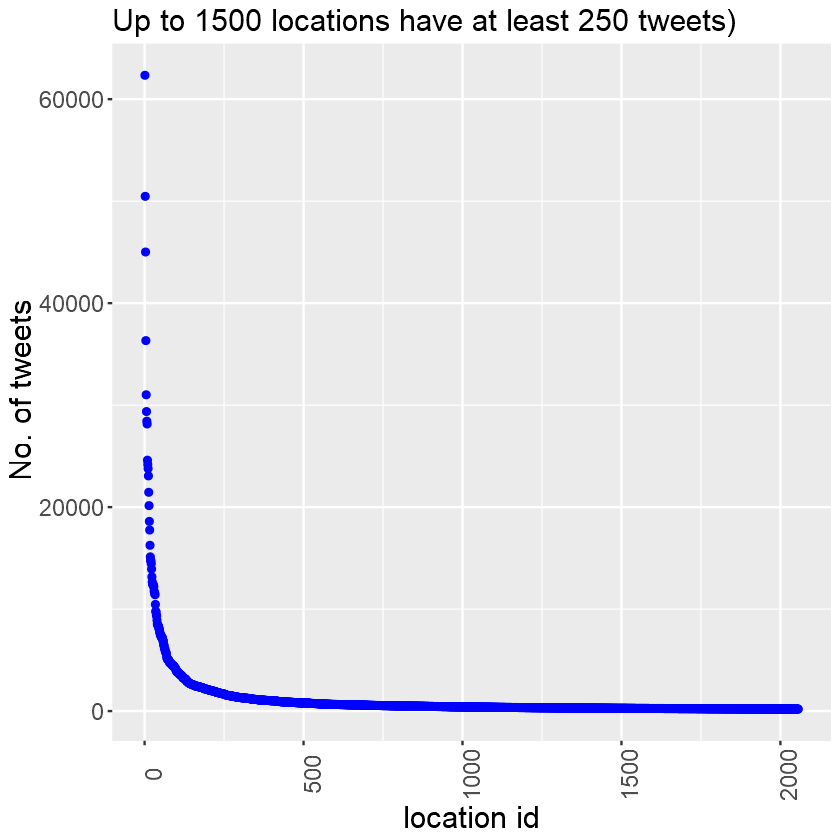

In [36]:
ggplot(aes(x = location_id, y = n), data = subset(get_usoer_locations, n > 200)) + # & text_id > 1)) +
  geom_point(color = "blue") +
       labs(title = "Up to 1500 locations have at least 250 tweets)", 
            x = "location id", y = "No. of tweets") + 
 theme(axis.text.x=element_text(angle=90)) +
      plot.format

###### Get unique City, State locations

In [37]:
 location <- usstates %>%
            dplyr::select(one_of(c("City_state", "City_code", "City2", "Place_type", "State", "Code"))) %>%
            filter(Place_type != "state") %>%
             mutate_all(funs(str_to_upper)) %>%
             mutate_all(funs(gsub("[,|.]", "", .))) %>%
            group_by(City_state, City_code, City2, State, Code) %>%
            dplyr::summarise(n = n()) %>%
            as.data.frame()

In [39]:
slice(location, 1330:1340)

City_state,City_code,City2,State,Code,n
AUBREY TEXAS,AUBREY TX,AUBREY,TEXAS,TX,2
AUBRY KANSAS,AUBRY KS,AUBRY,KANSAS,KS,1
AUBURN ALABAMA,AUBURN AL,AUBURN,ALABAMA,AL,2
AUBURN CALIFORNIA,AUBURN CA,AUBURN,CALIFORNIA,CA,2
AUBURN CITY (PT) GEORGIA,AUBURN CITY (PT) GA,AUBURN CITY (PT),GEORGIA,GA,2
AUBURN CITY (PT) INDIANA,AUBURN CITY (PT) IN,AUBURN CITY (PT),INDIANA,IN,4
AUBURN CITY (PT) WASHINGTON,AUBURN CITY (PT) WA,AUBURN CITY (PT),WASHINGTON,WA,2
AUBURN GEORGIA,AUBURN GA,AUBURN,GEORGIA,GA,1
AUBURN HILLS MICHIGAN,AUBURN HILLS MI,AUBURN HILLS,MICHIGAN,MI,4
AUBURN ILLINOIS,AUBURN IL,AUBURN,ILLINOIS,IL,5


In [ ]:
######### Combine ferg_cols user.locatios2 with any city, city state and city code information in location
######### code = 2 character state abbreviation  e.g. FL

In [40]:
ferg_temp <- ferg_cols %>%
                    dplyr::left_join(location, by = c("user.location2" = "City2")) %>%
                    as.data.frame()

In [41]:
ferg_temp_city_code <- ferg_cols %>%
                    dplyr::left_join(location, by = c("user.location2" = "City_code")) %>%
                    as.data.frame()

In [42]:
ferg_temp_city_code <- ferg_temp_city_code %>%
                        mutate(City_code =  str_c(City2, Code, sep = " ")) %>%
                        as.data.frame()

In [43]:
ferg_temp_city_state <- ferg_cols %>%
                    dplyr::inner_join(location, by = c("user.location2" = "City_state")) %>%
                    as.data.frame()

In [44]:
ferg_temp_city_state <- ferg_temp_city_state %>%
                        mutate(City_state =  str_c(City2, State, sep = " ")) %>%
                        as.data.frame()

In [45]:
colnames(ferg_temp_city_code)
colnames(ferg_temp_city_state)

[1] "rowno"                       "user.id"                    
 [3] "user.location"               "user.description"           
 [5] "created_at"                  "id"                         
 [7] "user.created_at"             "retweeted"                  
 [9] "retweeted_count"             "retweet"                    
[11] "retweeted_status.created_at" "favorited"                  
[13] "favorite_count"              "textnum"                    
[15] "full_text"                   "possibly_sensitive"         
[17] "hashtags"                    "lang"                       
[19] "user.geo_enabled"            "place.full_name"            
[21] "place.place_type"            "utc_datetime"               
[23] "yday"                        "ymd"                        
[25] "user_id2"                    "user.location2"             
[27] "City_state"                  "City2"                      
[29] "State"                       "Code"                       
[31] "n"                           "City_code"

[1] "rowno"                       "user.id"                    
 [3] "user.location"               "user.description"           
 [5] "created_at"                  "id"                         
 [7] "user.created_at"             "retweeted"                  
 [9] "retweeted_count"             "retweet"                    
[11] "retweeted_status.created_at" "favorited"                  
[13] "favorite_count"              "textnum"                    
[15] "full_text"                   "possibly_sensitive"         
[17] "hashtags"                    "lang"                       
[19] "user.geo_enabled"            "place.full_name"            
[21] "place.place_type"            "utc_datetime"               
[23] "yday"                        "ymd"                        
[25] "user_id2"                    "user.location2"             
[27] "City_code"                   "City2"                      
[29] "State"                       "Code"                       
[31] "n"                           "City_state"

In [ ]:
########## Reorder columns to have same structure

In [46]:
ferg_temp_city_code <- ferg_temp_city_code[c(1:26, 32, 27:31)]
ferg_temp_city_state <- ferg_temp_city_state[c(1:27, 32, 28:31)]

In [47]:
ferg_cols_loc <- rbind(ferg_temp_city_code, ferg_temp_city_state)

In [48]:
str(ferg_cols_loc)

'data.frame':	3883591 obs. of  32 variables:
 $ rowno                      : num  1 2 3 4 5 6 7 8 9 10 ...
 $ user.id                    : num  1.54e+09 9.44e+06 6.34e+07 1.54e+09 9.44e+06 ...
 $ user.location              : chr  "Columbus, OH" "Atlanta, GA" "CaLove" "Columbus, OH" ...
 $ user.description           : chr  "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." "Husband. Father. Prelate. Human. Company builder, 2 exits. Author @kingonomics. Inclusive ecosystem builder @th"| __truncated__ "Jealous Guardian of our Democracy #RIPTrayvonMartin #ImAlwaysWithHer" "Advocate for survivors of sexual violence. Breaker of silence, destroyer of shame." ...
 $ created_at                 : chr  "Sat Aug 09 22:33:06 +0000 2014" "Sat Aug 09 22:59:13 +0000 2014" "Sat Aug 09 22:00:02 +0000 2014" "Sat Aug 09 22:28:42 +0000 2014" ...
 $ id                         : num  4.98e+17 4.98e+17 4.98e+17 4.98e+17 4.98e+17 ...
 $ user.created_at            : chr  "Sat J

write.csv(ferg_cols_loc, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Source\\ferg_cols_location.csv")                

In [ ]:
######### Number of unique tweets for topic modelling and/or STSS

In [49]:
NROW(unique(ferg_cols_loc$full_text))

[1] 1179062

In [ ]:
###### Placeholder to read file ferg_cols_location.csv

ferg_cols_loc <- read.csv("C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Source\\ferg_cols_location.csv")

ferg_cols_loc$X <- NULL

### Spatiotemporal - Scanstatistics

In [ ]:
####### Remove locations where City_code is NA (code being 2 character state abbreviation)

In [50]:
NROW(unique(na.omit(ferg_cols_loc$City_code)))

[1] 7102

In [ ]:
####### Read in shape files and get lat, lon coordinates

In [56]:
cities_shp <- readOGR("../Preprocessing/Files/Maps/citiesx020", "citiesx020")

OGR data source with driver: ESRI Shapefile 
Source: "c:\Users\Laura\RyersonProject\Project\Preprocessing\Files\Maps\citiesx020", layer: "citiesx020"
with 28706 features
It has 11 fields
Integer64 fields read as strings:  CITIESX020 POP 


In [ ]:
####### Rename Saint Louis, Missouri to St Louis, Missouri

In [58]:
subset(cities_shp@data, cities_shp@data$STATE == "MO" & cities_shp@data$NAME %like% "St")

,AREA,PERIMETER,CITIESX020,FEATURE,NAME,FIPS,FIPS55,POP,STATE_FIPS,STATE,COUNTY
18379,0,0,18379,"Population less than 10,000",Cook Station,29055,16210,0,29,MO,Crawford County
18739,0,0,18739,"Population less than 10,000",Mount Sterling,29073,50654,0,29,MO,Gasconade County
18934,0,0,18934,"Population less than 10,000",Stanberry,29075,70270,1310,29,MO,Gentry County
18935,0,0,18935,"Population less than 10,000",Stanton,29071,70342,0,29,MO,Franklin County
18936,0,0,18936,"Population less than 10,000",Steele,29155,70558,2395,29,MO,Pemiscot County
18937,0,0,18937,"Population less than 10,000 County Seat",Steelville,29055,70576,1465,29,MO,Crawford County
18938,0,0,18938,"Population less than 10,000",Stella,29145,70648,132,29,MO,Newton County
18939,0,0,18939,"Population less than 10,000",Stewartsville,29063,70738,732,29,MO,Dekalb County
18940,0,0,18940,"Population less than 10,000",Stillings,29165,70774,0,29,MO,Platte County
18941,0,0,18941,"Population less than 10,000 County Seat",Stockton,29039,70828,1579,29,MO,Cedar County


In [59]:
cities_shp@data$NAME <- ifelse(str_detect(cities_shp@data$NAME, "Saint Louis") & 
                               str_detect(cities_shp@data$STATE, "MO"), "St Louis", cities_shp@data$NAME) 

In [ ]:
##### Extract latitiude and longitude center of each city

In [60]:
cities_coor <- gCentroid(cities_shp, byid = TRUE)

In [61]:
cities_latlon <- gCentroid(cities_shp, byid = TRUE) %>%
               as.data.frame() %>%
                dplyr::select(everything()) %>%
                dplyr::rename(lon = x, lat = y) %>%
                mutate(City = cities_shp@data$NAME, State = cities_shp@data$STATE, mapid = cities_shp@data$CITIESX020 
                      ) %>% 
                inner_join(as.data.frame(cities_shp), by = c("mapid" = "CITIESX020")) %>%
                mutate(City = toupper(City)) %>%
                dplyr::select(lon:STATE_FIPS, COUNTY) %>%
                as.data.frame()
                

                

In [62]:
colnames(cities_latlon) <- str_to_lower(colnames(cities_latlon))

In [63]:
head(cities_latlon)

lon,lat,city,state,mapid,area,perimeter,feature,name,fips,fips55,pop,state_fips,county
-123.8181,46.97494,7,WA,1,0,0,"Population 10,000 to 49,999",7,53027,00100,16565,53,Grays Harbor County
-122.2078,48.71663,34,WA,2,0,0,"Population less than 10,000",34,53073,00275,0,53,Whatcom County
-117.8391,48.35600,59,WA,3,0,0,"Population less than 10,000",59,53065,00380,0,53,Stevens County
-122.3628,47.33079,62,WA,4,0,0,"Population less than 10,000",62,53033,00415,0,53,King County
-123.0638,46.62849,70,WA,5,0,0,"Population less than 10,000",70,53041,00590,0,53,Lewis County
-118.9817,48.54705,75,WA,6,0,0,"Population less than 10,000",75,53047,00660,0,53,Okanogan County


write.csv(cities_latlon, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Maps\\cities_latlon.csv")

In [64]:
nrow(unique(cities_latlon))

[1] 28706

Number of city, state locations = 28,706

In [ ]:
####### Assign geospatial projections to cities shape file

In [65]:
getbormap <-  readOGR("../Preprocessing/Files/Maps/nyc_boroughs.geojson", "nyc_boroughs")

OGR data source with driver: GeoJSON 
Source: "c:\Users\Laura\RyersonProject\Project\Preprocessing\Files\Maps\nyc_boroughs.geojson", layer: "nyc_boroughs"
with 104 features
It has 3 fields


In [66]:
proj4string(getbormap)

[1] "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

In [67]:
proj4string(cities_shp) <- proj4string(getbormap)

######## Attach longitude and latidue data to Ferguson user locations, i.e. join (ferg_cols_loc) data to cities location (cities_latlon) data

In [68]:
fergcols_latlon <- ferg_cols_loc %>%
                    mutate(City2 = as.character(City2)) %>%
                    mutate(Code = as.character(Code)) %>%
                    left_join(cities_latlon, by = c("City2" = "city", "Code" = "state")) %>%
                    as.data.frame()

Warning message:
"Column `Code`/`state` joining character vector and factor, coercing into character vector"

In [ ]:
###### Get start and end dates for tweet activity

In [69]:
cat(paste0("Minimum datetime = ", min(fergcols_latlon$utc_datetime), "\n"))
cat(paste0("Maximum datetime = ",  max(fergcols_latlon$utc_datetime)))

Minimum datetime = 2014-08-09T05:33:30Z
Maximum datetime = 2014-08-20T01:17:04Z

In [ ]:
### Remove cities tnat have no geo-coordinates in cities_latlon (citiesx020)

In [76]:
str(fergcols_latlon2)

'data.frame':	72136 obs. of  44 variables:
 $ rowno                      : num  17 18 25 32 38 48 50 55 60 61 ...
 $ user.id                    : num  1.93e+07 3.91e+07 2.10e+07 5.98e+08 6.43e+07 ...
 $ user.location              : chr  "St Louis, MO" "St. Louis, MO" "St. Louis, MO" "St.Louis, MO" ...
 $ user.description           : chr  "Super Mom  â\200¢ Media Personality â\200¢ Voiceover Fiend â\200¢ Radio Chick â\200¢ Music Lover â\200¢ Travelh"| __truncated__ "STL + Running!!! + NKOTB &  corporate america = Lots of random tweets, you have been forewarned!" "I love life! I love my family!" "Oh you know.. Im amazing. Chef Life." ...
 $ created_at                 : chr  "Sat Aug 09 22:30:45 +0000 2014" "Sat Aug 09 22:28:58 +0000 2014" "Sat Aug 09 22:29:22 +0000 2014" "Sat Aug 09 22:38:41 +0000 2014" ...
 $ id                         : num  4.98e+17 4.98e+17 4.98e+17 4.98e+17 4.98e+17 ...
 $ user.created_at            : chr  "Wed Jan 21 23:05:58 +0000 2009" "Sun May 10 20:52:59 +0000 

In [79]:
fergcols_latlon2 <- subset(fergcols_latlon, !(is.na(name)))

In [80]:
nrow(fergcols_latlon2)

[1] 72136

Not all user locations i.e. City, state combinations have geo-coordinates in fergcols_latlon2 (cities_latlon)

In [81]:

ID <- fergcols_latlon2[c("City_code")] %>%
                    
                    group_indices(City_code)
                   

In [82]:
fergcols_latlon2 <- cbind(ID, fergcols_latlon2)

In [ ]:
### Daily tweet distribution over the entire 12 day period.

In [216]:
table(fergcols_latlon2$yday - min(fergcols_latlon2$yday) + 1)


     1      2      3      4      5      6      7      8      9     10     11 
   113  10452  27384  38708  28957 239613  72570  50103  71882 150982 158486 
    12 
 12714 

In [ ]:
Day 6 has 150% more tweets than the next highest days - Day 10 and 11

In [ ]:
####### Create a dataframe ferg_latlon_n to examine some spatial statistics

In [84]:
ferg_latlon_n <- fergcols_latlon2 %>%
                    dplyr::select(one_of(c("City_code", "lon", "lat", "yday", "ID"))) %>%
                                       mutate(tday = (yday - min(yday) + 1)) %>%
                                        group_by(City_code, tday) %>% 
                                                 dplyr::summarise(n = n(),
                                                                 lon = mean(lon),
                                                                 lat = mean(lat)) %>%
                                                dplyr::rename(count = n, time = tday, 
                                                              location = City_code) %>%
                                                    as.data.frame()

write.csv(ferg_latlon_n, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Features_Demo\\ferg_latlon_n.csv")

ferg_latlon_n <- read.csv("C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Features_Demo\\ferg_latlon_n.csv")

ferg_latlon_n$X <- NULL

In [ ]:
##### Plot spatial locations of tweets

In [ ]:
##### Remove any dupilcate locations

In [85]:
latlon <- subset(ferg_latlon_n, !duplicated(ferg_latlon_n$location))

In [ ]:
###### Load the usstates_placetype file to get populations (2015) for cities in ferg_latlon_n.

In [91]:
usstates_place <- read.csv("../Preprocessing/Files/Demographics/usstates_placetype.csv", stringsAsFactors = FALSE)

In [95]:
usstates_place$X<- NULL
usstates_place$X.1 <- NULL

In [94]:
colnames(ferg_latlon_n)

[1] "location" "time"     "count"    "lon"      "lat"

In [96]:
ferg_latlon_pop <- usstates_place %>% dplyr::select(one_of(c("Code", "State", "State_id", "City2",
                                                           "Place_type", "City_state",
                                                           "City_code", "Census2010pop", 
                                                           "Popestimate2015"))) %>%
                                        
                                    group_by(Code, State, State_id, City2, #Place_type, 
                                                 City_state, City_code) %>%
                                                summarise(avgCensus2010pop 
                                                          = mean(Census2010pop),
                                                            avgPopestimate2015 = 
                                                          mean(Popestimate2015)) %>%
                                        mutate(City_code = gsub(",", "", toupper(as.character(City_code)))) %>%
                                        inner_join(ferg_latlon_n, 
                                                  by = c("City_code" = "location")) %>%
                                        dplyr::rename("location" = "City_code") %>%
                                    #    dplyr::rename("count" = "count1") %>%
                                        as.data.frame()

In [97]:
ferg_latlon_pop$rownum <- seq(1, nrow(ferg_latlon_pop), 1)

In [98]:
tweets_latlon <- ferg_latlon_pop %>% dplyr::select(everything()) %>%
            group_by(location, lon, lat) %>%
            summarise(num_tweets = sum(count)) %>%
            arrange(desc(num_tweets)) %>%
            as.data.frame()

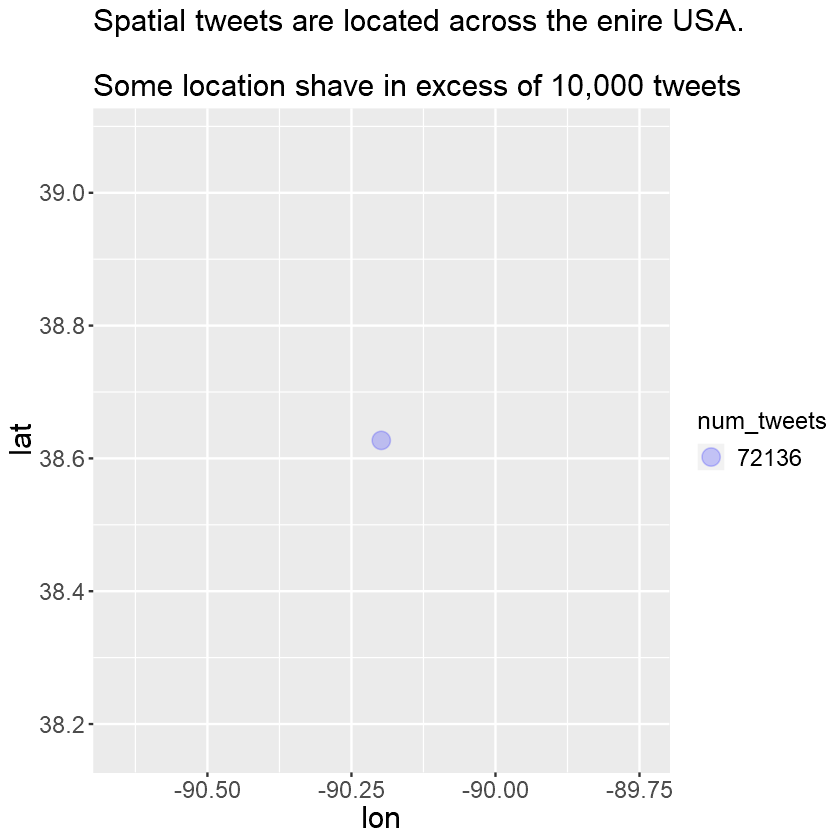

In [100]:
ggplot(aes(y=lat, x=lon), data = tweets_latlon) +
    geom_point(aes(size = num_tweets), alpha = 0.2, color = "blue") +
    labs(title = "Spatial tweets are located across the enire USA. \n
Some location shave in excess of 10,000 tweets", xlab = "longitude", ylab = "latitude") +
    plot.format

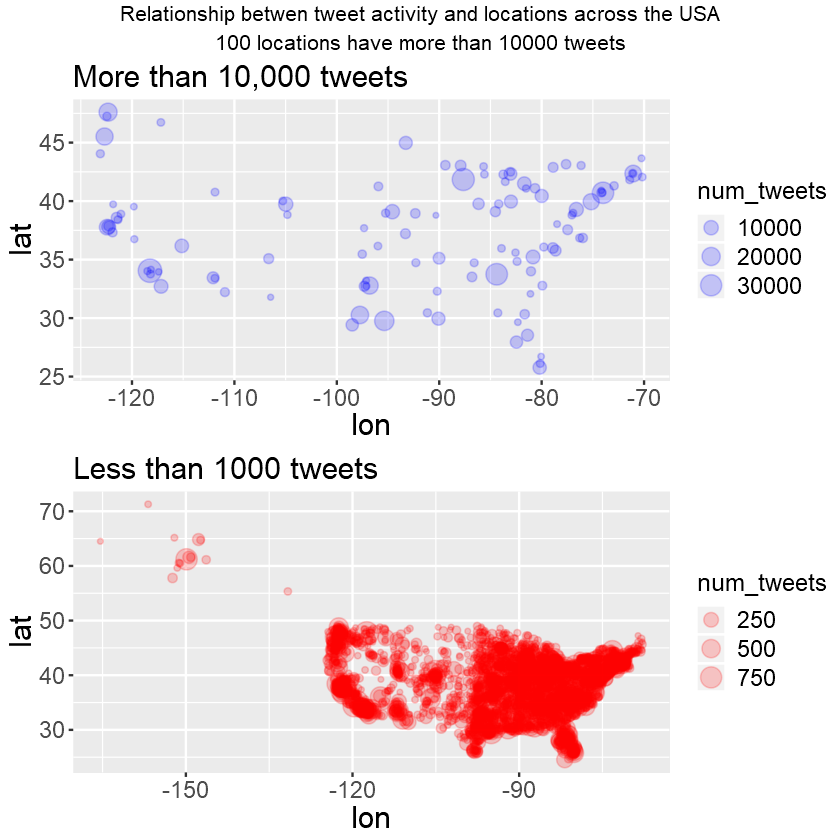

In [49]:
p1 <- ggplot(aes(y=lat, x=lon), data = subset(tweets_latlon, num_tweets > 1000)) +
    geom_point(aes(size = num_tweets), alpha = 0.2, color = "blue") +
    labs(title = "More than 10,000 tweets", xlab = "longitude", ylab = "latitude") +
    plot.format

p2 <- ggplot(aes(y=lat, x=lon), data = subset(tweets_latlon, num_tweets < 1000)) +
    geom_point(aes(size = num_tweets), alpha = 0.2, color = "red") +
    labs(title = "Less than 1000 tweets", xlab = "longitude", ylab = "latitude") +
    plot.format

grid.arrange(p1, p2, ncol = 1, top="Relationship betwen tweet activity and locations across the USA\n100 locations have more than 10000 tweets")

write.csv(ferg_latlon_pop, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\Features_Demo\\ferg_latlon_pop.csv")